<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/LakeWSE-Estimation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install xee -q

In [2]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [3]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

In [ ]:
map=geemap.Map(basemap="SATELLITE")
map

Sorting by latitude (north-south cross-section).


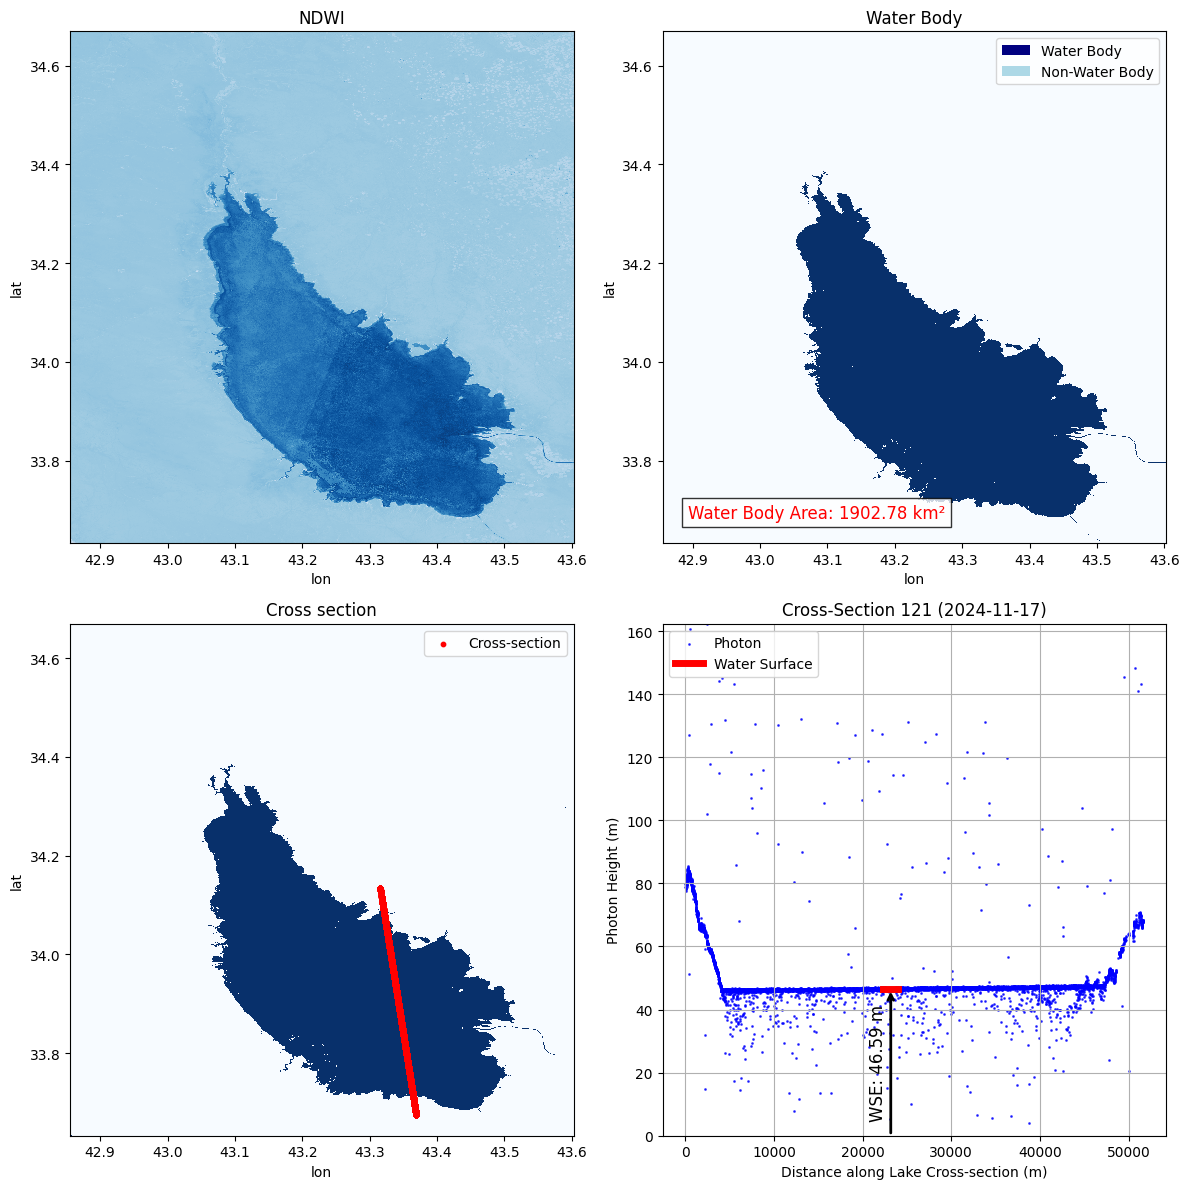

In [5]:
roi = map.draw_last_feature.geometry()
start_time = '2024-01-01'
end_time = '2024-12-31'

landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi).filterDate(start_time, end_time)

def ndwi(img):
    qa = img.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 3).neq(0)
    cirrus = qa.bitwiseAnd(1 << 2).neq(0)
    shadow = qa.bitwiseAnd(1 << 4).neq(0)
    mask = cloud.Or(cirrus).Or(shadow)
    bands = img.select('SR.*').multiply(2.75e-05).add(-0.2)
    index = bands.normalizedDifference(['SR_B3','SR_B5']).rename('ndwi')
    return index.updateMask(mask.Not()).copyProperties(img, img.propertyNames())

landsat_ndwi = landsat.map(ndwi)

ds = xr.open_dataset(landsat_ndwi, engine='ee', crs='EPSG:4326', scale=0.000269, geometry=roi)
ds_mean = ds.mean('time')

# KMeans clustering with fixed label logic
model = KMeans(n_clusters=2, random_state=42)
df = ds_mean.to_dataframe()
df['clustering_raw'] = model.fit_predict(df[['ndwi']])
cluster_means = df.groupby('clustering_raw')['ndwi'].mean()
water_cluster_label = cluster_means.idxmax()
df['clustering'] = (df['clustering_raw'] == water_cluster_label).astype(int)
xarr = df.to_xarray().sortby('lon').sortby('lat')

lake_pixels = (xarr.clustering == 1).sum().item()
lake_area_km2 = lake_pixels * 900 / 1_000_000

# ------------------------------ Photon Data Processing ------------------------------

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.stats import gaussian_kde
import os
import re

Initial_file_path = '/content/photon_2024-11-17_t944_1747852981863.csv'
df_initial = pd.read_csv(Initial_file_path)
latitude = df_initial.iloc[:, 1].values
longitude = df_initial.iloc[:, 2].values
photon_height = df_initial.iloc[:, 3].values

# Extract date from filename
filename = os.path.basename(Initial_file_path)
match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
Date = match.group() if match else "Unknown"

# Sorting by lat/lon
lat_range = max(latitude) - min(latitude)
lon_range = max(longitude) - min(longitude)
if lat_range > lon_range:
    sorted_indices = np.argsort(latitude)
    print("Sorting by latitude (north-south cross-section).")
else:
    sorted_indices = np.argsort(longitude)
    print("Sorting by longitude (east-west cross-section).")

latitude = latitude[sorted_indices]
longitude = longitude[sorted_indices]
photon_height = photon_height[sorted_indices]

# Hampel Filter
def hampel_filter(data, window_size=20, threshold=7):
    filtered_data = data.copy()
    half_window = window_size // 2
    for i in range(half_window, len(data) - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = median
    return filtered_data

stronger_filtered_photon_height = hampel_filter(photon_height, window_size=20, threshold=7)
final_filtered_photon_height = medfilt(stronger_filtered_photon_height, kernel_size=5)

# Cross-section distance calculation
lat_to_meters = 111320
lon_to_meters = 40075000 * np.cos(np.radians(np.mean(latitude))) / 360
cross_section_distances = np.cumsum(
    np.sqrt(np.diff(latitude)**2 * lat_to_meters**2 + np.diff(longitude)**2 * lon_to_meters**2)
)
cross_section_distances = np.insert(cross_section_distances, 0, 0)

# KDE-based WSE detection
kde = gaussian_kde(final_filtered_photon_height)
photon_height_range = np.linspace(min(final_filtered_photon_height), max(final_filtered_photon_height), 1000)
density_values = kde(photon_height_range)
peak_height = photon_height_range[np.argmax(density_values)]

water_surface_mask = (final_filtered_photon_height >= peak_height - 0.2) & (final_filtered_photon_height <= peak_height)
water_surface_heights = final_filtered_photon_height[water_surface_mask]
water_surface_distances = cross_section_distances[water_surface_mask]

# Histogram-based width detection
bin_width = 100
bins = np.arange(min(water_surface_distances), max(water_surface_distances) + bin_width, bin_width)
hist, bin_edges = np.histogram(water_surface_distances, bins=bins)
threshold = 10
valid_bins = hist >= threshold

max_len = 0
start_idx = 0
temp_len = 0
temp_start = 0

for i in range(len(valid_bins)):
    if valid_bins[i]:
        if temp_len == 0:
            temp_start = i
        temp_len += 1
        if temp_len > max_len:
            max_len = temp_len
            start_idx = temp_start
    else:
        temp_len = 0

if max_len == 0:
    raise ValueError("No continuous water surface segment found. Try lowering the threshold.")

left_bank = bin_edges[start_idx]
right_bank = bin_edges[start_idx + max_len]
river_width = right_bank - left_bank
average_water_surface_height = np.mean(water_surface_heights)

trimmed_mask = (cross_section_distances >= left_bank) & (cross_section_distances <= right_bank)
trimmed_distances = cross_section_distances[trimmed_mask]
trimmed_surface = np.full_like(trimmed_distances, average_water_surface_height)

# ------------------------------ Plotting ------------------------------

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

# NDWI plot
ds_mean.ndwi.plot(
    ax=axes[0, 0],
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=-1,
    vmax=1,
    add_colorbar=False
)
axes[0, 0].set_title("NDWI")

# Clustering map
xarr.clustering.plot(
    ax=axes[0, 1],
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=0,
    vmax=1,
    add_colorbar=False
)
axes[0, 1].set_title("Water Body")
axes[0, 1].text(
    0.05, 0.05, f"Water Body Area: {lake_area_km2:.2f} km²",
    transform=axes[0, 1].transAxes,
    fontsize=12, color='red',
    bbox=dict(facecolor='white', alpha=0.8)
)
legend_elements = [
    Patch(facecolor='navy', label='Water Body'),
    Patch(facecolor='lightblue', label='Non-Water Body')
]
axes[0, 1].legend(handles=legend_elements, loc='upper right', fontsize=10)

# Cross-section on clustering map
xarr.clustering.plot(
    ax=axes[1, 0],
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=0,
    vmax=1,
    add_colorbar=False
)
axes[1, 0].scatter(longitude, latitude, s=10, color='red', label='Cross-section')
axes[1, 0].set_title("Cross section")
axes[1, 0].legend(loc='upper right', fontsize=10)

# WSE Profile
ax = axes[1, 1]
ax.scatter(cross_section_distances, photon_height, color='blue', s=1, alpha=0.7, label="Photon")
ax.plot(trimmed_distances, trimmed_surface, color='red', linewidth=5, label="Water Surface")

center_of_river = (left_bank + right_bank) / 2
ax.annotate('', xy=(center_of_river, average_water_surface_height), xytext=(center_of_river, 0),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(center_of_river - 2500, average_water_surface_height / 2,
        f'WSE: {average_water_surface_height:.2f} m',
        verticalalignment='center', fontsize=12, color='black', rotation=90)

ax.set_title(f'Cross-Section 121 ({Date})')
ax.set_xlabel("Distance along Lake Cross-section (m)")
ax.set_ylabel("Photon Height (m)")
ax.set_ylim(0, max(photon_height))
ax.legend(loc='best')
ax.grid(True)

plt.tight_layout()
plt.show()
